In [1]:
#%pip install -U pretty_midi
import pretty_midi
import os
import numpy as np
import pandas as pd
#%pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score, f1_score,classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

In [2]:
data_dir = "Four_composers"

### Extract the relevant features from each MIDI file. Store the features in a list X, and the associated composer in a list y. 

In [3]:
import warnings

def extract_features(midi_file):
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning, message="Tempo, Key or Time signature change events found on non-zero tracks")
            midi_data = pretty_midi.PrettyMIDI(midi_file)
    except IOError as e:
        print(f"Error reading file {midi_file}: {str(e)}")
        return None
    except Exception as e:
        print(f"Error parsing MIDI file {midi_file}: {str(e)}")
        return None

    try:
        tempo_changes = midi_data.get_tempo_changes()
        tempo = tempo_changes[1][0] if len(tempo_changes) > 1 and len(tempo_changes[1]) > 0 else 120
    except IndexError:
        tempo = 120

    num_instruments = len(midi_data.instruments)
    
    total_velocity = 0
    total_notes = 0
    for instrument in midi_data.instruments:
        total_velocity += sum(note.velocity for note in instrument.notes)
        total_notes += len(instrument.notes)
    
    avg_velocity = total_velocity / total_notes if total_notes > 0 else 0
    
    pitch_classes = [0] * 12
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            pitch_classes[note.pitch % 12] += 1
    
    # Ignore key signature errors
    try:
        key = midi_data.key_signature_changes[0].key_number if midi_data.key_signature_changes else 0
    except (ValueError, IndexError):
        key = 0

    return [tempo, num_instruments, avg_velocity, key] + pitch_classes

X = []
y = []
error_count = 0
for composer in os.listdir(data_dir):
    composer_dir = os.path.join(data_dir, composer)
    if os.path.isdir(composer_dir):
        for root, dirs, files in os.walk(composer_dir):
            for midi_file in files:
                if midi_file.endswith('.mid'):
                    file_path = os.path.join(root, midi_file)
                    features = extract_features(file_path)
                    if features is not None:
                        X.append(features)
                        y.append(composer)
                    else:
                        error_count += 1
                        print(f"Skipping file {file_path} due to errors")

if error_count == 0:
    print("No errors found in dataset.")

No errors found in dataset.


### Convert X into an array. Perform train-test split.

In [4]:
X = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Standard Scaling on X_train and X_test.

In [5]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### SMOTE resampling on the training sets

In [6]:
%pip install -U -q imbalanced-learn
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_scaled_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

Note: you may need to restart the kernel to use updated packages.


### Visualize the data imbalance, and correction after SMOTE.

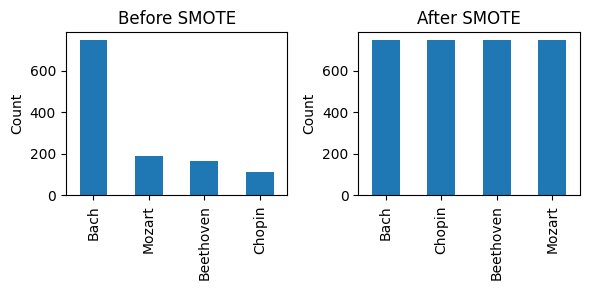

In [7]:
# Convert y_train and y_train_smote to pandas Series
y_train_series = pd.Series(y_train)
y_train_smote_series = pd.Series(y_train_smote)

f = plt.figure(figsize=(6, 3))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Plot before SMOTE
ax1 = f.add_subplot(1, 2, 1)
y_train_series.value_counts().plot(kind='bar', ax=ax1)
ax1.set_title("Before SMOTE")
ax1.set_ylabel("Count")

# Plot after SMOTE
ax2 = f.add_subplot(1, 2, 2)
y_train_smote_series.value_counts().plot(kind='bar', ax=ax2)
ax2.set_title("After SMOTE")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()

### SVM

In [8]:
# Train a Support Vector Machine classifier
svm_clf = SVC(kernel='rbf', gamma=0.4, degree=5, C=18.0, decision_function_shape='ovr')
svm_clf.fit(X_train_scaled_smote, y_train_smote)

SVC(C=18.0, degree=5, gamma=0.4)

### Train model using radial basis vector kernel.

In [9]:
y_pred = svm_clf.predict(X_test_scaled)
rbf_accuracy = accuracy_score(y_test, y_pred)
rbf_f1 = f1_score(y_test, y_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  76.80
F1 (RBF Kernel):  77.22


In [10]:
# Generate and print the classification report
report = classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

        Bach       0.94      0.90      0.92       177
   Beethoven       0.48      0.67      0.56        43
      Chopin       0.52      0.50      0.51        22
      Mozart       0.66      0.55      0.60        64

    accuracy                           0.77       306
   macro avg       0.65      0.66      0.65       306
weighted avg       0.78      0.77      0.77       306



### Print confusion matrix.

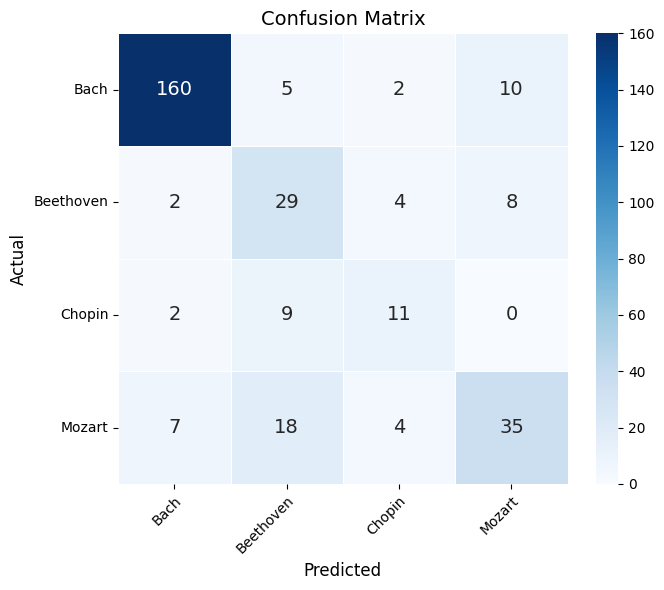

In [11]:
labels = sorted(set(y_test) | set(y_pred))

cmatrix = confusion_matrix(y_test, y_pred, labels=labels)
fontsize = 7
figsize = (7, 6)  # Increased figure size for better readability
cmap = plt.colormaps.get_cmap("Blues")
fig, ax = plt.subplots(figsize=figsize)

sns.heatmap(cmatrix, 
            annot=True, 
            cmap=cmap, 
            cbar=True, 
            ax=ax, 
            linewidths=0.5,
            fmt='d',
            annot_kws={'fontsize': 14},
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right")

plt.tight_layout()
plt.show()

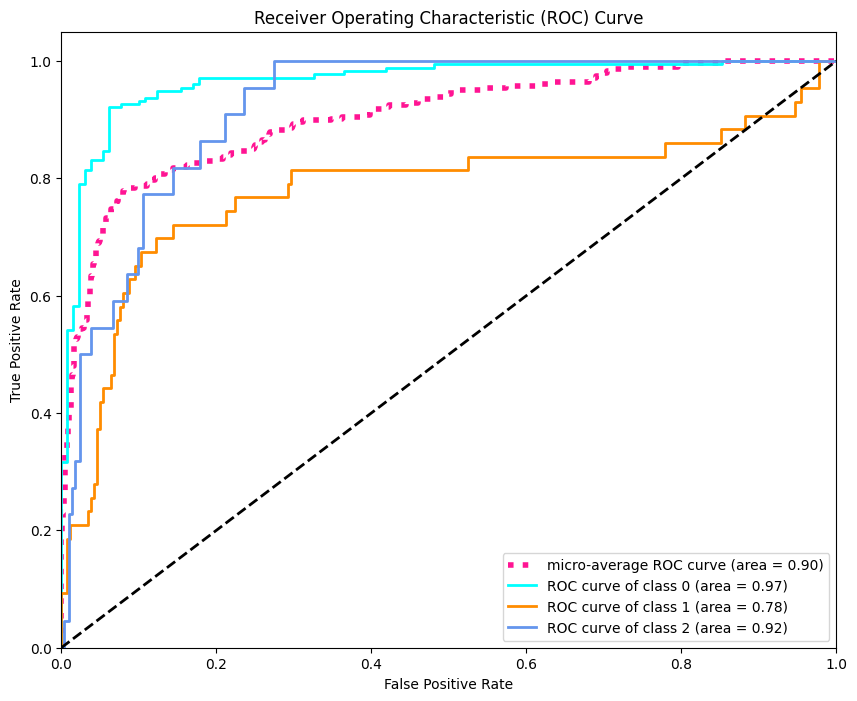

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Get predicted probabilities
y_pred_proba = svm_clf.decision_function(X_test_scaled)

# Binarize the output
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()